((n+2p-f)/s)+1

mirar errores por clases
mirar manualmente errores de clasificacion en el valid dataset. para entender de donde pueden venir los errores.
confussion matrix?? pytorch o tiene metodos. usar sklearn

weight decay parameter of optimizer (10e-3, 10e-2, 10e-1)

# 0. Import libraries

In [92]:
import pandas as pd
import numpy as np

import torch
from torchvision import transforms
import torch.nn as nn

from sklearn.metrics import *

import matplotlib.pyplot as plt
%matplotlib inline

# 1. Explore the data:

### Reading csv and counting entries:

In [78]:
train_df = pd.read_csv('./input/train.csv')

n_train = len(train_df)
n_pixels = len(train_df.columns) - 1
n_class = len(set(train_df['label']))

print('Number of training samples: {0}'.format(n_train))
print('Number of training pixels: {0}'.format(n_pixels))
print('Number of classes: {0}'.format(n_class))

test_df = pd.read_csv('./input/test.csv')

n_test = len(test_df)
n_pixels = len(test_df.columns)

print('Number of train samples: {0}'.format(n_test))
print('Number of test pixels: {0}'.format(n_pixels))

Number of training samples: 42000
Number of training pixels: 784
Number of classes: 10
Number of train samples: 28000
Number of test pixels: 784


### Display some images with its labels from training set:

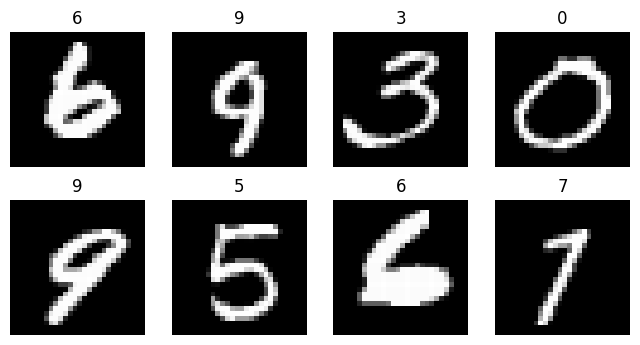

In [79]:
figure = plt.figure(figsize=(8, 4))
cols, rows = 4, 2
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_df), size=(1,)).item()
    img = np.array((train_df.iloc[sample_idx, 1:].values).reshape(28, 28))
    label = train_df.iloc[sample_idx, 0]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img,cmap="gray")
plt.show()

### Histogram of the classes (0-9)

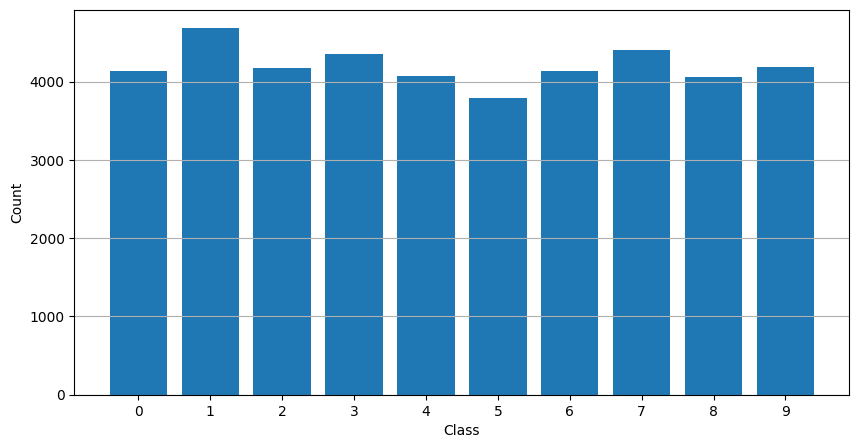

In [80]:
plt.rcParams['figure.figsize'] = (10, 5)
plt.bar(train_df['label'].value_counts().index, train_df['label'].value_counts())
plt.xticks(np.arange(n_class))
plt.xlabel('Class', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.grid('on', axis='y')

# 2. Modeling and Creating Data for Training and Validation:

### Data model:
A custom Dataset class must implement three functions: __init__, __len__, and __getitem__.
The __init__ function is run once when instantiating the Dataset object. We initialize the directory containing the images, the annotations file, 
and both transforms (covered in more detail in the next section).

In [81]:
class CustomImageDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, transform=None):
        self.data = dataframe
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        label = self.data.iloc[index,0] #first column where the label is
        image = torch.tensor(list(self.data.iloc[index,1:]),dtype=torch.float) #all columns but first
        image = image / image.max() #to set the range to [0,1]
        image = image.reshape(28,28).unsqueeze(0)  #convert from (784) to (28,28)

        if self.transform is not None:
            image = self.transform(image)
            
        return image, label  #image should be either a narray or a PIL image

### Transforms:
Data does not always come in its final processed form that is required for training machine learning algorithms. 
We use transforms to perform some manipulation of the data and make it suitable for training.
For training, we need the features as normalized tensors, and the labels as one-hot encoded tensors.
    transform to modify the features and target_transform to modify the labels.


In [82]:
transform_train = transforms.Compose([
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

### Creating datasets:

In [83]:
BATCH_SIZE = 64
TRAINING_SIZE = 0.9

full_training_dataset = CustomImageDataset(train_df, transform=transform_train)
training_train_sample, training_valid_sample = torch.utils.data.random_split(full_training_dataset, [TRAINING_SIZE, 1- TRAINING_SIZE])

train_loader = torch.utils.data.DataLoader(training_train_sample, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = torch.utils.data.DataLoader(training_valid_sample, batch_size=BATCH_SIZE, shuffle=True)

# 3. Building the neural network:
Neural networks comprise of layers/modules that perform operations on data. The torch.nn namespace provides all the building blocks you need to build your own neural network. Every module in PyTorch subclasses the nn.Module. A neural network is a module itself that consists of other modules (layers). This nested structure allows for building and managing complex architectures easily.

### Get device for training:

In [84]:
# Checking GPU is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('Training on CPU...')
else:
    print('Training on GPU...')

Training on CPU...


### Define the network structure:

In [85]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 4 * 4, 120)  # 5*5 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = torch.nn.functional.max_pool2d(torch.nn.functional.relu(self.conv1(x)), (2, 2))
        # If the size is a square, you can specify with a single number
        x = torch.nn.functional.max_pool2d(torch.nn.functional.relu(self.conv2(x)), 2)
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = Net()
print(model)

# if train_on_gpu:
#     model = model.to()

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


# 4. Training and evaluation:
To use the model, we pass it the input data. This executes the model’s forward, along with some background operations. Do not call model.forward() directly!

Calling the model on the input returns a 2-dimensional tensor with dim=0 corresponding to each output of 10 raw predicted values for each class, and dim=1 corresponding to the individual values of each output. We get the prediction probabilities by passing it through an instance of the nn.Softmax module.

In [86]:
LEARNING_RATE = 1e-2
MOMENTUM = 0.9

criterion = nn.CrossEntropyLoss()
optim = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

In [87]:
epochs = 10
valid_loss_min = np.Inf
train_losses, valid_losses = [], []
train_accuracies, valid_accuracies = [], []

for epoch in range(1, epochs+1):

    # TRAINING!!
    training_loss = 0.0
    training_accuracy = 0
    total = 0
    correct = 0

    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        # Clear the gradients, do this because gradients are accumulated.
        optim.zero_grad()
        # Forward pass, get our log-probabilities.
        ps = model(inputs)

        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(ps.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        training_accuracy+= correct / total
        
        # Compute the loss (how far is the output from being correct).
        loss = criterion(ps, labels)
        # Backpropagate this error through the network. 
        # Autograd calculates and stores the gradients for each model parameter in the parameter’s .grad attribute.
        loss.backward()    
        # initiate gradient descent. The optimizer adjusts each parameter by its gradient stored in .grad.
        optim.step()

        training_loss += loss.item()


    # VALIDATION!!
    else:
        valid_loss = 0
        valid_accuracy = 0
        correct = 0
        total = 0

        # since we're not training, we don't need to calculate the gradients for our outputs
        with torch.no_grad():
            for data in valid_loader:
                images, labels = data
                # calculate outputs by running images through the network
                outputs = model(images)
                # the class with the highest energy is what we choose as prediction
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                valid_accuracy+= correct / total

                valid_loss += criterion(outputs, labels)

        model.train() # change the network to training mode
        
        train_losses.append(training_loss/len(train_loader))
        valid_losses.append(valid_loss/len(valid_loader))
        valid_accuracies.append(valid_accuracy/len(valid_loader))
        train_accuracies.append(training_accuracy/len(train_loader))

        network_learned = valid_loss < valid_loss_min

        print(f"Epoch: {epoch}/{epochs}.. ",
                f"Training Loss: {training_loss/len(train_loader):.3f}.. ",
                f"Validation Loss: {valid_loss/len(valid_loader):.3f}.. ",
                f"Training Accuracy: {training_accuracy/len(train_loader):.3f}",
                f"Valid Accuracy: {valid_accuracy/len(valid_loader):.3f}")
        if network_learned:
            valid_loss_min = valid_loss
            torch.save(model.state_dict(), 'CNN_model.pt')
            print('Detected network improvement, saving current model')


Epoch: 1/10..  Training Loss: 0.576..  Validation Loss: 0.112..  Training Accuracy: 0.570 Valid Accuracy: 0.967
Detected network improvement, saving current model
Epoch: 2/10..  Training Loss: 0.081..  Validation Loss: 0.073..  Training Accuracy: 0.973 Valid Accuracy: 0.981
Detected network improvement, saving current model
Epoch: 3/10..  Training Loss: 0.059..  Validation Loss: 0.070..  Training Accuracy: 0.981 Valid Accuracy: 0.980
Detected network improvement, saving current model
Epoch: 4/10..  Training Loss: 0.044..  Validation Loss: 0.058..  Training Accuracy: 0.985 Valid Accuracy: 0.985
Detected network improvement, saving current model
Epoch: 5/10..  Training Loss: 0.036..  Validation Loss: 0.046..  Training Accuracy: 0.988 Valid Accuracy: 0.987
Detected network improvement, saving current model
Epoch: 6/10..  Training Loss: 0.030..  Validation Loss: 0.044..  Training Accuracy: 0.991 Valid Accuracy: 0.985
Detected network improvement, saving current model
Epoch: 7/10..  Trainin

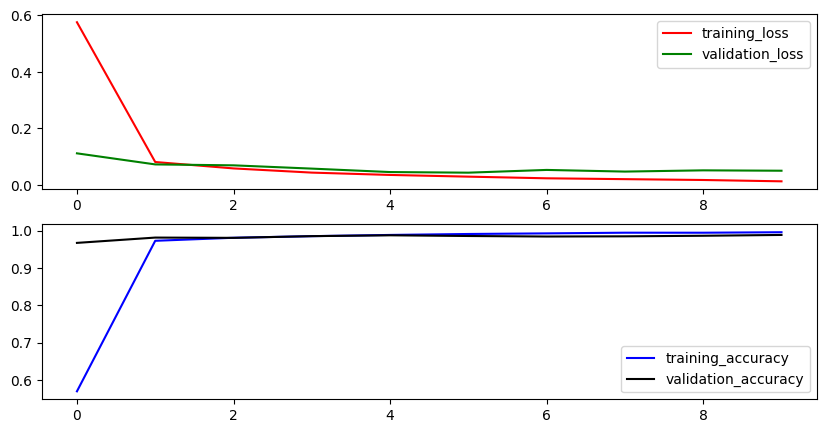

In [88]:
plt.subplot(2, 1, 1)
line1 = plt.plot(train_losses, c='red')
line2 = plt.plot(valid_losses, c='green')
plt.legend(['training_loss', 'validation_loss'])

plt.subplot(2, 1, 2)
line3 = plt.plot(train_accuracies, c='blue')
line4 = plt.plot(valid_accuracies, c='black')

plt.legend(['training_accuracy', 'validation_accuracy'])
plt.show()

### Accuracy per class:

In [90]:
# prepare to count predictions for each class
classes = ('0','1','2','3','4','5','6','7','8','9')
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in valid_loader:
        images, labels = data
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: 0     is 100.0 %
Accuracy for class: 1     is 99.8 %
Accuracy for class: 2     is 98.5 %
Accuracy for class: 3     is 98.9 %
Accuracy for class: 4     is 99.2 %
Accuracy for class: 5     is 99.0 %
Accuracy for class: 6     is 99.5 %
Accuracy for class: 7     is 96.9 %
Accuracy for class: 8     is 97.3 %
Accuracy for class: 9     is 98.8 %


### Confusion Matrix:

Accuracy of the network on valid images:  0.9876160990712074


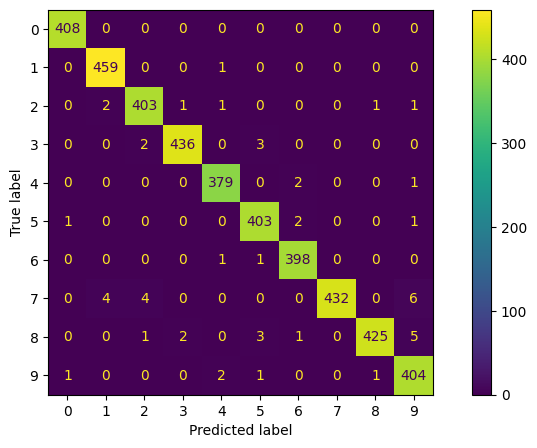

In [94]:
correct = 0
total = 0
predicted_list =  []
labels_list = []
with torch.no_grad():
    for data in valid_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        predicted_list.append(predicted)
        total += labels.size(0)
        labels_list.append(labels)
        correct += (predicted == labels).sum().item()
print('Accuracy of the network on valid images: ', correct/total)
labels_tensor = torch.cat(labels_list,dim=0)
predicted_tensor = torch.cat(predicted_list,dim=0)
cm = confusion_matrix(labels_tensor,predicted_tensor)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# SUBMIT:

In [97]:
test_df = pd.read_csv('./input/test.csv')
test_df.values.shape
test_tensor = torch.tensor(test_df.values, dtype=torch.float) / 255
test_tensor = test_tensor.view(-1, 1, 28, 28)
outputs = model(test_tensor)
_, predicted = torch.max(outputs, 1)
submit_df = pd.DataFrame({'ImageId': np.arange(1, 28001), 'Label': predicted.numpy()})
submit_df.to_csv('submition.csv', index=False)